In [19]:
from bs4 import BeautifulSoup
import requests 
import pandas as pd
import matplotlib.pyplot as plt 
import re                              

In [20]:
page = requests.get("https://nofluffjobs.com/pl/praca-it?gclid=CjwKCAiAx8KQBhAGEiwAD3EiP2Gv_3iff4ljIpkmrZzF9DToiMl54LtdlYNuc9Tgy25MY1hz9ORqkRoCQtAQAvD_BwE&criteria=seniority%3Dtrainee,junior&page=1").text 
soup = BeautifulSoup(page, "html.parser")

In [21]:
# Find number of pages                            
pages = soup.find_all("a", class_="page-link")    
last = 1                                          
for page in pages:                                
    page_num = page.get_text(" ", strip=True)     
    # Exclude the skip sign                       
    if page_num == "»":                           
        continue                                  
    if int(page_num) > last:                      
        last = int(page_num)                      

In [22]:
job_offers = []                                                                                                                  
                                                                                                                                 
# Search through all pages                                                                                                       
for page in range(1, last+1):                                                                                                    
    url = f"https://nofluffjobs.com/pl/praca-it?gclid=CjwKCAiAx8KQBhAGEiwAD3EiP2Gv_3iff4ljIpkmrZzF9DToiMl54LtdlYNuc9Tgy25MY1hz9ORqkRoCQtAQAvD_BwE&criteria=seniority%3Dtrainee,junior&page={page}" 
    r = requests.get(url).text                                                                                                   
    soup = BeautifulSoup(r, "html.parser")                                                                                       
                                                                                                                                 
    # Narrow down results                                                                                                        
    divs = soup.find("div", class_="list-container ng-star-inserted")                                                            
                                                                                                                                 
    # Prepare a dataset                                                                                                          
    for div in divs.contents:                                                                                                    
                                                                                                                                 
        dict = {}                                                                                                                
        title = div.find("h3")                                                                                                   
        if title == -1:                                                                                                          
            continue                                                                                                             
        dict["title"] = title.get_text("", strip=True)                                                                           
        nfj = div.find("nfj-posting-item-tags")                                                                                  
        span = nfj.find("span")                                                                                                  
        if span == None:                                                                                                         
            continue                                                                                                             
        salary = nfj.find("span").get_text("", strip=True).split("-")                                                            
        min_salary = int(nfj.find("span").get_text("", strip=True).split("-")[0].replace('\xa0', '').replace("PLN", ""))         
        dict["min_salary"] = min_salary                                                                                          
                                                                                                                                 
        if len(salary) == 1:                                                                                                     
            max_salary = None                                                                                                    
        else:                                                                                                                    
            max_salary = int(nfj.find("span").get_text("", strip=True).split("-")[1].replace('\xa0', '').replace("PLN", ""))     
        dict["max_salary"] = max_salary                                                                                          
                                                                                                                                 
        location = span.findNext("span").get_text(" ", strip=True).split(" ")[0].replace(",", "").lower()                        
        dict["location"] = location                                                                                              
                                                                                                                                 
        # Append list                                                                                                            
        job_offers.append(dict)                                                                                                  
                                                                                                                                 
# Convert to a dataframe                                                                                                         
df = pd.DataFrame(data=job_offers) 
df

,title,min_salary,max_salary,location
0,Junior Java Developer,5500,11000.0,zdalna
1,Software Engineering Intern,5000,8000.0,zdalna
2,Software Developer,7000,11000.0,łódź
3,(Not just a) Junior Developer,8500,12000.0,kraków
4,QGC developer,18000,20000.0,zdalna
...,...,...,...,...
916,UX/UI Designer,5706,7609.0,budapest
917,C++ Developer,7609,10779.0,budapest
918,Junior Software Developer,6341,8877.0,budapest
919,Junior Presales,5072,5706.0,budapest


In [23]:
# Clean data
# Delete locations outside Poland
# Clean data                                           
df = df.drop(df.index[df['location'] == 'budapest'])   
df = df.drop(df.index[df['location'] == 'debrecen'])   
df = df.drop(df.index[df['location'] == 'szombathely'])
df = df.drop(df.index[df['location'] == 'kecskemét']) 

In [24]:
# Change special characters in location
df['location'] = df['location'].str.replace('ó', 'o')  
df['location'] = df['location'].str.replace('ł', 'l')  
df['location'] = df['location'].str.replace('ń', 'n')  
df['location'] = df['location'].str.replace('ź', 'z')


In [25]:
# Standardize name for Warsaw                                     
df['location'] = df['location'].str.replace('warsaw', 'warszawa') 

In [26]:
# Type for min_salary 
df['min_salary'] = df['min_salary'].astype(int)
df

,title,min_salary,max_salary,location
0,Junior Java Developer,5500,11000.0,zdalna
1,Software Engineering Intern,5000,8000.0,zdalna
2,Software Developer,7000,11000.0,lodz
3,(Not just a) Junior Developer,8500,12000.0,krakow
4,QGC developer,18000,20000.0,zdalna
...,...,...,...,...
899,Remote Linux Administrator,12000,16000.0,zdalna
900,Junior Mobile Developer,7609,10145.0,zdalna
901,ERP TANÁCSADÓ / BUSINESS ANALYST,7609,11413.0,zdalna
902,Jr Business Analyst,8877,11413.0,zdalna


In [27]:
# Crete a new column category based on values in job title column                                          
df['category'] = "other"                                                                                   
                                                                                                           
def FillCategory(pattern, column, new_value):                                                              
                                                                                                           
    for index, value in column.iteritems():                                                                
        pattern = re.compile(pattern)                                                                      
        match_object = pattern.search(value.lower())                                                       
        if match_object != None:                                                                           
            index_num = index                                                                              
            df.loc[index_num, 'category'] = new_value                                                      
                                                                                                           
FillCategory(r'test|qa|quality assurance', df['title'], "testing")                                         
FillCategory(r'bi', df['title'], "business intelligence")                                                  
FillCategory(r'java', df['title'], "java")                                                                 
FillCategory(r'fullstack|web develop|node', df['title'], "fullstack")                                      
FillCategory(r'angular|react|front-?end|vue|js|javascript|flutter|wordpress', df['title'], "frontend")     
FillCategory(r'.net|c#', df['title'], ".NET/C#")                                                           
FillCategory(r'business', df['title'], "business analysis")                                                
FillCategory(r'backend|ruby', df['title'], "backend")                                                      
FillCategory(r'python', df['title'], "python")                                                             
FillCategory(r'support|desk|helpdesk|wsparcia', df['title'], "support")                                    
FillCategory(r'devops', df['title'], "devOps")                                                             
FillCategory(r'ios|android|mobile|app develop+', df['title'], "mobile")                                     
FillCategory(r'sql|database|data', df['title'], "data")                                                    
FillCategory(r'php', df['title'], "PHP")                                                                   
FillCategory(r'data scien+', df['title'], "data science")                                                   
FillCategory(r'manager|management|owner', df['title'], "management")                                       
FillCategory(r'software', df['title'], "software development")                                             
FillCategory(r'ux|ui', df['title'], "UX/UI")                                                               
FillCategory(r'admini+', df['title'], "administration")                                                  
FillCategory(r'sap|erp|sales ?force', df['title'], "HR/office")                                             
FillCategory(r'blockchain', df['title'], "blockchain")                                                    
FillCategory(r'c/c\++|c\++| c | c \++', df['title'], "C/C++")                                             
FillCategory(r'aws|azure|cloud', df['title'], "cloud")                                                     
FillCategory(r'designer', df['title'], "creative design")
df
                                                                                                           

,title,min_salary,max_salary,location,category
0,Junior Java Developer,5500,11000.0,zdalna,java
1,Software Engineering Intern,5000,8000.0,zdalna,software development
2,Software Developer,7000,11000.0,lodz,software development
3,(Not just a) Junior Developer,8500,12000.0,krakow,other
4,QGC developer,18000,20000.0,zdalna,other
...,...,...,...,...,...
899,Remote Linux Administrator,12000,16000.0,zdalna,administration
900,Junior Mobile Developer,7609,10145.0,zdalna,mobile
901,ERP TANÁCSADÓ / BUSINESS ANALYST,7609,11413.0,zdalna,HR/office
902,Jr Business Analyst,8877,11413.0,zdalna,business analysis


In [28]:
# Offers by location
grouped_by_location = df.groupby(['location']).size().sort_values(ascending=False).head(n=8)
grouped_by_location

location
zdalna      441
warszawa    149
krakow       82
wroclaw      48
lodz         24
gdansk       23
poznan       19
gdynia       14
dtype: int64

<AxesSubplot:>

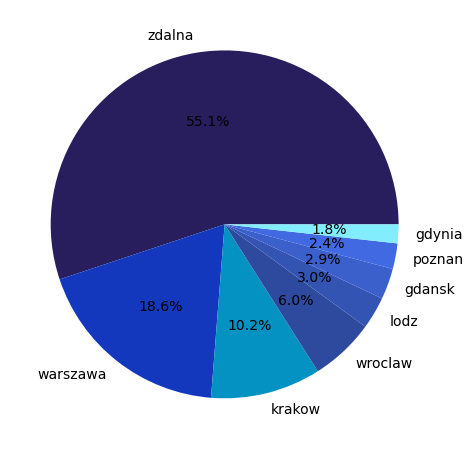

In [29]:
# Visualize data
fig1 = grouped_by_location.plot.pie(x="location", y="number", autopct='%1.1f%%', ylabel="", figsize=(8,8), fontsize=14 ,colors = ['#281E5D', '#1338BE', '#0492C2', '#2E4A9E', '#3454B4', '#3B5FCB', '#4169E1', '#82EEFD'])
fig1

In [30]:
# Number od offers by category
grouped_by_category = df.groupby(['category']).size().sort_values(ascending=False)
grouped_by_category

category
other                    120
frontend                 113
java                      72
testing                   64
.NET/C#                   60
software development      57
support                   51
PHP                       43
devOps                    30
fullstack                 29
data                      26
python                    24
mobile                    24
C/C++                     24
backend                   23
administration            23
management                22
business analysis         21
cloud                     19
creative design           16
HR/office                 14
business intelligence     11
UX/UI                     11
data science               4
blockchain                 3
dtype: int64

<AxesSubplot:>

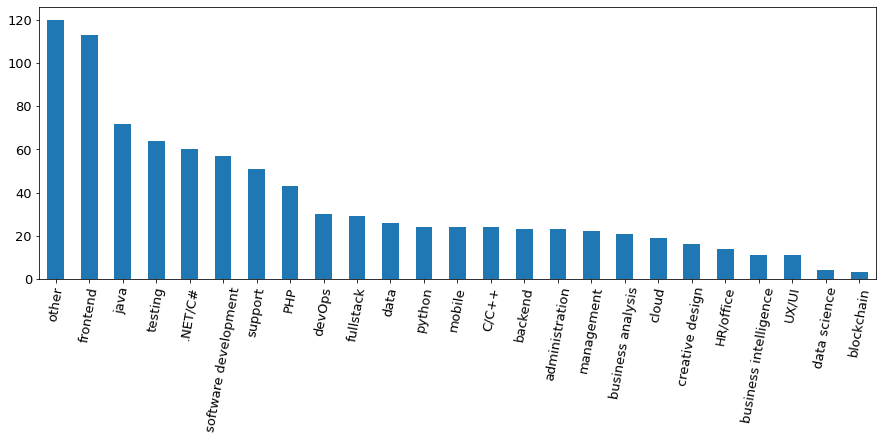

In [31]:
# Visualize data
fig2 = grouped_by_category.plot.bar(x="category", y="number", xlabel="", fontsize=13, figsize=(15,5))
plt.xticks(rotation=80)
fig2

In [32]:
# Min and max salary per category
# Avg min salary per category
avg_min = df.groupby('category')['min_salary'].mean().astype(int).reset_index()
avg_min

,category,min_salary
0,.NET/C#,6676
1,C/C++,5666
2,HR/office,5243
3,PHP,5169
4,UX/UI,6408
5,administration,7008
6,backend,7080
7,blockchain,6333
8,business analysis,7561
9,business intelligence,6774


In [33]:
# Avg max salary per category
avg_max = df.groupby('category')['max_salary'].mean().astype(int).reset_index()
avg_max

,category,max_salary
0,.NET/C#,10413
1,C/C++,9433
2,HR/office,8701
3,PHP,8611
4,UX/UI,10407
5,administration,9438
6,backend,9533
7,blockchain,9333
8,business analysis,10710
9,business intelligence,10014


In [34]:
avg_sal = pd.merge(avg_min, avg_max, how='inner', on = 'category')
avg_sal

,category,min_salary,max_salary
0,.NET/C#,6676,10413
1,C/C++,5666,9433
2,HR/office,5243,8701
3,PHP,5169,8611
4,UX/UI,6408,10407
5,administration,7008,9438
6,backend,7080,9533
7,blockchain,6333,9333
8,business analysis,7561,10710
9,business intelligence,6774,10014


<AxesSubplot:xlabel='category'>

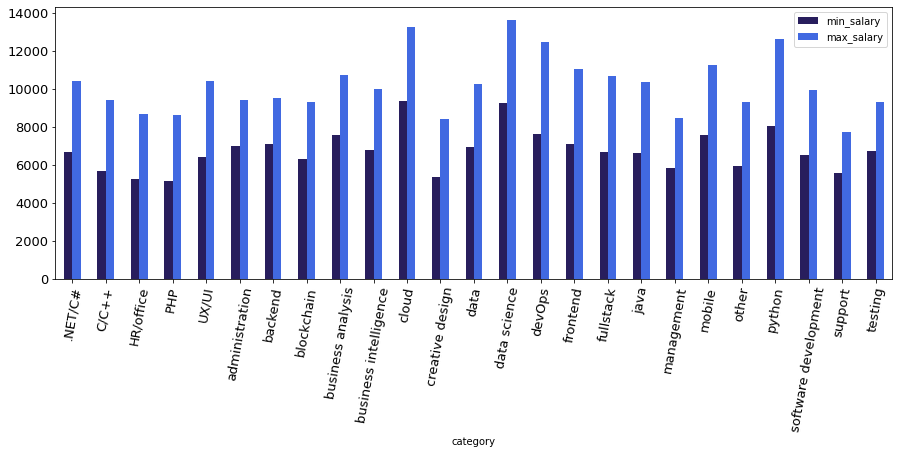

In [35]:
# Visualize data from avg_sal dataframe
fig3 = avg_sal.plot.bar(x='category', y=['min_salary', 'max_salary'], figsize=(15,5), color=['#281E5D','#4169E1'], fontsize=13)
plt.xticks(rotation=80)
fig3